In [1]:
generate_data = True

In [2]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import scipy as scp
import scipy.io as sio

import warnings
warnings.filterwarnings('ignore')

from frictionlaws import SlipWeakeningFrictionLaw
from predictions import *

import pickle

In [3]:
# Phase diagram of which values of tau and G can act as barriers.
if generate_data:
    dt = 1e-3
    tmax = 300
    gamma = 0.65
    beta = 1e-3
    output_interval = 50
    data = []
    x_barrier = 40

    tau_all = np.logspace(-2,0,25)
    dc_all = np.logspace(-4,0,25)
    L_arrest = np.zeros([np.size(tau_all),np.size(dc_all)])

    for i in range(np.size(tau_all)):
        print(i)
        for j in range(np.size(dc_all)):

            x = np.linspace(0,100,10000)
            tau = gauss(x,0,1)*(1-tau_all[i]) + tau_all[i]
            tau[0]=1
            dc = (dc_all[j]-1e-100)*gauss(x,x_barrier,.01)*0# + 1e-100
            dc[x>=x_barrier]=dc_all[j]

            # run
            data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta, bc='fixed',frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x))))

            # Find L_arrest
            L_arrest[i,j]=x[np.max(np.where(data['u'][:,-1]>0))]

    # Prediction
    tau_all_pred = np.logspace(-2,0,25)
    dc_all_pred = np.logspace(-4,0,25)
    L_arrest_pred = np.zeros([np.size(tau_all_pred),np.size(dc_all_pred)])
    for i in range(np.size(tau_all_pred)):
        for j in range(np.size(dc_all_pred)):
            x = np.linspace(0,100,10000)
            tau = gauss(x,0,1)*(1-tau_all_pred[i]) + tau_all_pred[i]
            tau[0]=1
            dc = (dc_all_pred[j]-1e-100)*gauss(x,x_barrier,.01)*0
            dc[x>=x_barrier]=dc_all_pred[j]

            u_pred = PulsePrediction(startPos = 0, u = data['u'][0:1], x = x, tau = tau, gamma = 0.65, dc = dc)
            L_arrest_pred[i,j]=x[np.max(np.where(u_pred>0))]            
            
            
    # Run example simulation:
    dt = 1e-3
    tmax = 200
    gamma = 0.65
    beta = 1e-3
    output_interval = 100
    barrierVal = 1.7e-1

    x = np.linspace(0,100,10000)
    tau = gauss(x,0,1)*.7 +.3
    tau[0]=1
    dc = (barrierVal-1e-100)*gauss(x,40,.01) + 1e-100
    dc[x>40]=barrierVal    
    tau[x>90]=-.5

    # run
    dataBarrier = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta, bc='fixed',frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x))))

    pickle.dump({'gamma': gamma, 'x_barrier': x_barrier, 'tau_all': tau_all, 'dc_all': dc_all, 'L_arrest': L_arrest, 'tau_all_pred': tau_all_pred, 'dc_all_pred': dc_all_pred, 'L_arrest_pred': L_arrest_pred, 'dataBarrier': dataBarrier},  open( "data/pulse_fracture_energy.p", "wb" ))            
else:
    data = pickle.load( open( "data/pulse_fracture_energy.p", "rb" ) )
    tau_all = data['tau_all']
    dc_all = data['dc_all']
    L_arrest = data['L_arrest']
    dataBarrier = data['dataBarrier']
    tau_all_pred = data['tau_all_pred']
    dc_all_pred = data['dc_all_pred']
    L_arrest_pred = data['L_arrest_pred']  
    x_barrier = data['x_barrier']
    gamma = data['gamma']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


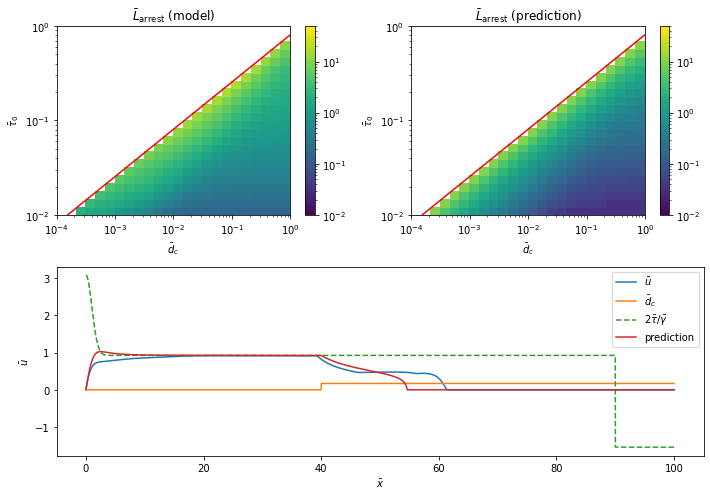

In [4]:
fig = plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
L = L_arrest-x_barrier
L[L>=59]=-1
plt.pcolormesh(dc_all,tau_all,L,norm=colors.LogNorm(vmin=1e-2, vmax=50))
plt.colorbar()
plt.plot(dc_all,(dc_all*gamma)**0.5,'r')
plt.yscale('log')
plt.xscale('log')
plt.title('$\\bar L_\mathrm{arrest}$ (model)')
plt.xlabel('$\\bar d_c$')
plt.ylabel('$\\bar \\tau_0$')
plt.axis([1e-4, 1, 1e-2, 1])

plt.subplot(2,2,2)
L = L_arrest_pred-x_barrier
L[L>=59]=-1
plt.pcolormesh(dc_all_pred,tau_all_pred,L,norm=colors.LogNorm(vmin=1e-2, vmax=50))
plt.colorbar()
plt.plot(dc_all_pred,(dc_all_pred*gamma)**0.5,'r')
plt.yscale('log')
plt.xscale('log')
plt.title('$\\bar L_\mathrm{arrest}$ (prediction)')
plt.xlabel('$\\bar d_c$')
plt.ylabel('$\\bar \\tau_0$')
plt.axis([1e-4, 1, 1e-2, 1])

plt.subplot(2,2,(3,4))

u_pred = PulsePrediction(startPos = 0, u = dataBarrier['u'], x = dataBarrier['x'],tau = dataBarrier['tau'], gamma = dataBarrier['gamma'],dc = dataBarrier['frictionLaw'].dc)
plt.plot(dataBarrier['x'],dataBarrier['u'][:,-1],label='$\\bar u$')
plt.plot(dataBarrier['x'],dataBarrier['frictionLaw'].dc,label='$\\bar d_c$')
plt.plot(dataBarrier['x'],2*dataBarrier['tau']/dataBarrier['gamma'],label='$2\\bar \\tau/\\bar \\gamma$',linestyle='--')
plt.plot(dataBarrier['x'],u_pred,label='prediction',linestyle='-')    
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar u$')    
plt.legend()

plt.tight_layout()

plt.savefig('figures/arrest_length_dc.eps', format='eps')

plt.show()